# Chapter 5. Classification

**Classification and propensity score**: 
1. Establish a cutoff probability for the class of interest, above which we consider a record as belonging to that class
2. Estimate with any model the probability that a record belongs to the class of interest
3. If that probability is above the cutoff probability, assign the new record to the class of interest 

The higher the cutoff, the fewer the records predicted as belonging to the class of interest. The lower the cutoff, the more the records predicted. 

**More than two categories**: Even in the case of more than two outcomes, the problem can often be recast into a series of binary problems using conditional probabilities. For example Y = 0,1,2. Predict Y = 0 or Y > 0. Given that Y > 0, predict whether Y = 1 or Y = 2. 

## 5.1 Naive bayes

The naive bayes algorithm uses the probability of observing predictor values, given an outcome, to estimate what is really of interest: the probability of observing outcome Y = i, given a set of predictor values 

**Conditional probability**: the probability of observing some event (say, X = i) given some other event (say, Y = i), written as P(Xi | Yi)

**Posterior probability**: the probability of an outcome after the predictor information has been incorporated (in contrast to the prior probability of outcomes, not taking predictor information into account)

**Complete or exact bayesian classification**
For each record to be classified:
1. Find all the other records with the same predictor profile (i.e. where the predictor values are the same)
2. Determine what classes those records belong to and which class is most prevalent (i.e. probable)
3. Assign that class to the new record

Note: predictor variables must be categorical (factor) variables in the standard naive bayes algorithm

### Why exact bayesian classification is impractical

When the number of predictor variables exceeds a handful, many of the records to be classified will be without exact matches. Considering a model to predict voting on the basis of demographic variables. Even a sizable sample may not contain even a single match for a new record who is a male Hispanic with high income from the US Midwest who voted in the last election, did not vote in the prior election, has three daughters and one son, and is divorced. And this is with just eight variables, a small number for most classification problems. The addition of just a single new variable with five equally frequent categories reduces the probability of a match by a factor of 5

### The naive solution

**Naive bayes** we no longer restrict the probability calculation to those records that match the record to be classified. Instead, we use the entire data set. 
1. For a binary response Y = i (i = 0 or 1), estimate the individual conditional probabilities for each predictor P(Xj | Y = i). These are the probabilities that the predictor value is in the record when we observe Y = i. This probability is estimated by the proportion of Xj values among the Y = i records in the training set
2. Multiply these probabilities by each other, and then by the proportion of records belonging to Y = i
3. Repeat steps 1 and 2 for all the classes
4. Estimate a probability for outcome i by taking the value calculated in step 2 for class i and dividing it by the sum of such values for all classes
5. Assign the record to the class with the highest probability for this set of predictor values

**Exact Bayes classification**:

P(Y = i|X1,X2,…,Xp) = P(Y = i)P(X1,…,Xp|Y = i) / P(Y = 0)P(X1,…,Xp|Y = 0) + P(Y = 1)P(X1,…,Xp|Y = 1)...

**Naive bayes**:

Under the naive bayes assumption of conditional independence, the equation changes into:

P(Y = i|X1,X2,…,Xp) = P(Y = i)P(X1|Y = i)…P(Xp|Y = i) / P(Y = 0)P(X1|Y = 0)…P(Xp|Y = 0) + P(Y = 1)P(X1|Y =1)...

Why is this formula called naive? We have made a simplifying assumption that the exact conditional probability of a vector of predictor values, given observing an outcome, is sufficiently well estimated by the product of the individual conditional probabilities P(Xj|Y=i). In other words, in estimating P(Xj|Y=i) instead of P(X1,X2,...Xp|Y=i), we are assuming Xj is independent of all the other predictor variables Xk for k ≠ j

In [1]:
import pandas as pd
import numpy as np
from sklearn.naive_bayes import MultinomialNB

loan_data = pd.read_csv('/Users/boyuan/Desktop/OneDrive/practical-statistics-for-data-scientists-master/data/loan_data.csv.gz',
                        compression = 'gzip')
loan_data.head()

,Unnamed: 0,status,loan_amnt,term,annual_inc,dti,payment_inc_ratio,revol_bal,revol_util,purpose,...,delinq_2yrs_zero,pub_rec_zero,open_acc,grade,outcome,emp_length,purpose_,home_,emp_len_,borrower_score
0,1,Charged Off,2500,60 months,30000,1.00,2.39320,1687,9.4,car,...,1,1,3,4.8,default,1,major_purchase,RENT,> 1 Year,0.65
1,2,Charged Off,5600,60 months,40000,5.55,4.57170,5210,32.6,small_business,...,1,1,11,1.4,default,5,small_business,OWN,> 1 Year,0.80
2,3,Charged Off,5375,60 months,15000,18.08,9.71600,9279,36.5,other,...,1,1,2,6.0,default,1,other,RENT,> 1 Year,0.60
3,4,Charged Off,9000,36 months,30000,10.08,12.21520,10452,91.7,debt_consolidation,...,1,1,4,4.2,default,1,debt_consolidation,RENT,> 1 Year,0.50
4,5,Charged Off,10000,36 months,100000,7.06,3.90888,11997,55.5,other,...,1,1,14,5.4,default,4,other,RENT,> 1 Year,0.55


In [2]:
# convert to categorical
loan_data.outcome = loan_data.outcome.astype('category')
loan_data.outcome.cat.reorder_categories(['paid off', 'default'])
loan_data.purpose_ = loan_data.purpose_.astype('category')
loan_data.home_ = loan_data.home_.astype('category')
loan_data.emp_len_ = loan_data.emp_len_.astype('category')

In [3]:
predictors = ['purpose_', 'home_', 'emp_len_']
outcome = 'outcome'
X = pd.get_dummies(loan_data[predictors], prefix='', prefix_sep='')
y = loan_data[outcome]

naive_model = MultinomialNB(alpha=0.01, fit_prior=True)
naive_model.fit(X, y)

MultinomialNB(alpha=0.01, class_prior=None, fit_prior=True)

In [4]:
naive_model.feature_log_prob_

array([[-2.98568079, -1.65075848, -3.91515406, -4.38810745, -5.34359996,
        -3.25614089, -4.18335906, -1.93946238, -3.58417726, -1.82144088,
        -4.15016524, -1.14705315],
       [-2.77207366, -1.69253222, -3.73665122, -4.02494832, -5.34977262,
        -3.40212145, -4.96201704, -1.81302493, -3.6131958 , -1.94345848,
        -4.57066335, -1.13015885]])

In [6]:
new_loan = X.loc[146:146, :]
new_loan

,credit_card,debt_consolidation,home_improvement,major_purchase,medical,other,small_business,MORTGAGE,OWN,RENT,< 1 Year,> 1 Year
146,0,0,0,0,0,0,1,1,0,0,0,1


In [7]:
y[146]

'default'

In [8]:
print('predicted class: ', naive_model.predict(new_loan)[0])
probabilities = pd.DataFrame(naive_model.predict_proba(new_loan),
                             columns = loan_data[outcome].cat.categories)
print('predicted probabilities', probabilities)

predicted class:  default
predicted probabilities     default  paid off
0  0.653696  0.346304


The naive bayes classifier is known to produce biased estimates. However, where the goal is to rank records according to the probability that Y = 1, unbiased estimates of probability are not needed, and naive bayes produces good results

### Numeric predictor variables

The bayesian classifier works only with categorical predictors (e.g. with spam classification, where the presence or absence of words, phrases, characters, and so on lies at the heart of the predictive task). To apply naive bayes to numerical predictors, one of the two approaches must be taken:
1. Bin and convert the numerical predictors to categorical predictors and apply the algorithm
2. Use a probability model - for example, the normal distribution - to estimate the conditional probability P(Xj|Y=i)

**Caution**: When a predictor category is absent in the training data, the algorithm assigns zero probability to the outcome variable in new data, rather than simply ignoring this variable and using the information from other variables, as other methods might. Most implementations of Naive Bayes use a smoothing parameter (Laplace Smoothing) to prevent this

## 5.2 Discriminant analysis

Covariance: a measure of the extent to which one variable in concert with another (i.e. similar magnitude and direction)

Discriminant function: the function that, when applied to the predictor variables, maximizes the separation of the classes

Discriminant weights: the scores that result from the application of the discriminant function and are used to estimate probabilities of belonging to one class or another

**Linear discriminant analysis, or LDA**: is now less widely used with the advent of more sophisticated techniques, such as tree models and logistic regression

Note: Linear discriminant analysis should not be confused with Latent Dirichlet Allocation, also referred to as LDA. Latent Dirichlet Allocation is used in text and natural language processing and is unrelated to linear discriminant analysis

### Covariance matrix

The covariance measures the relationship between two variables x and z.

As with the correlation coefficient, positive values indicate a positive relationship and negative values indicate a negative relationship. Correlation, however, is constrained to be between –1 and 1, whereas covariance scale depends on the scale of the variables x and z.

### Fisher's linear discriminant

To predict a binary outcome y using just two continuous numeric variables (x, z). Technically, discriminant analysis assumes the predictor variables are normally distributed continuous variables, but, in practice, the method works well even for nonextreme departures from normality, and for binary predictors.

Fisher’s linear discriminant distinguishes variation between groups, on the one hand, from variation within groups on the other. Specifically, seeking to divide the records into two groups, linear discriminant analysis (LDA) focuses on maximizing the “between” sum of squares SSbetween (measuring the variation between the two groups) relative to the “within” sum of squares SSwithin (measuring the within-group variation). In this case, the two groups correspond to the records (x0, z0) for which y = 0 and the records (x1, z1) for which y = 1. The method finds the linear combination wxx + wzz that maximizes that sum of squares ratio: SSbetween/SSwithin

The between sum of squares is the squared distance between the two group means, and the within sum of squares is the spread around the means within each group, weighted by the covariance matrix. Intuitively, by maximizing the between sum of squares and minimizing the within sum of squares, this method yields the greatest separation between the two groups.

### A simple example

In [9]:
loan3000 = pd.read_csv('/Users/boyuan/Desktop/OneDrive/practical-statistics-for-data-scientists-master/data/loan3000.csv')
loan3000.head()

,Unnamed: 0,outcome,purpose_,dti,borrower_score,payment_inc_ratio
0,32109,paid off,debt_consolidation,21.23,0.40,5.11135
1,16982,default,credit_card,15.49,0.40,5.43165
2,25335,paid off,debt_consolidation,27.30,0.70,9.23003
3,34580,paid off,major_purchase,21.11,0.40,2.33482
4,14424,default,debt_consolidation,16.46,0.45,12.10320


In [12]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

loan3000.outcome = loan3000.outcome.astype('category')

predictors = ['borrower_score', 'payment_inc_ratio']
outcome = 'outcome'

X = loan3000[predictors]
y = loan3000[outcome]

loan_lda = LinearDiscriminantAnalysis()
loan_lda.fit(X, y)

pd.DataFrame(loan_lda.scalings_, index = X.columns)

,0
borrower_score,7.175839
payment_inc_ratio,-0.099676


**Using discriminant analysis for feature selection**: If the predictor variables are normalized prior to running LDA, the discriminator weights are measures of variable importance, thus providing a computationally efficient method of feature selection

In [13]:
pred = pd.DataFrame(loan_lda.predict_proba(loan3000[predictors]),
                    columns = loan_lda.classes_)
pred.head()

,default,paid off
0,0.553544,0.446456
1,0.558953,0.441047
2,0.272696,0.727304
3,0.506254,0.493746
4,0.609952,0.390048


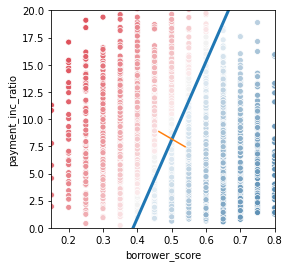

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

# Use scalings and center of means to determine decision boundary
center = np.mean(loan_lda.means_, axis=0)
slope = - loan_lda.scalings_[0] / loan_lda.scalings_[1]
intercept = center[1] - center[0] * slope

# payment_inc_ratio for borrower_score of 0 and 20
x_0 = (0 - intercept) / slope
x_20 = (20 - intercept) / slope

lda_df = pd.concat([loan3000, pred['default']], axis=1)
lda_df.head()

fig, ax = plt.subplots(figsize=(4, 4))
g = sns.scatterplot(x='borrower_score', y='payment_inc_ratio',
                    hue='default', data=lda_df,
                    palette=sns.diverging_palette(240, 10, n=9, as_cmap=True),
                    ax=ax, legend=False)

ax.set_ylim(0, 20)
ax.set_xlim(0.15, 0.8)
ax.plot((x_0, x_20), (0, 20), linewidth=3)
ax.plot(*loan_lda.means_.transpose())

**Extensions of discriminant analysis:** 
1. More predictor variables: while the text and example in this section used just two predictor variables, LDA works just as well with more than two predictor variables. The only limiting factor is the number of records (estimating the covariance matrix requires a sufficient number of records per variable, which is typically not an issue in data science applications).
2. There are other variants of discriminant analysis. The best known is quadratic discriminant analysis (QDA). Despite its name, QDA is still a linear discriminant function. The main difference is that in LDA, the covariance matrix is assumed to be the same for the two groups corresponding to Y = 0 and Y = 1. In QDA, the covariance matrix is allowed to be different for the two groups. In practice, the difference in most applications is not critical.

## 5.3 Logistic regression

## 5.4 Evaluating classification models

## 5.5 Strategies for imbalanced data